## Advanced Lane Finding Project

The goals / steps of this project are the following:

Camera Calibration
1. Compute the camera calibration using chessboard images

Pipeline (Single Image):
1. Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Pipeline (Video):

---
## Camera Calibration
## 1. Compute the camera calibration using chessboard images

This function gets image points (and object points) for the inside corners of all the calibration images. Then calculates the calibration matrix and distortion coefficients:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Helper function
# Plot two color images (read by plt, not cv2) side by side for comparison, and save the plot
def plot_2figures(img1, img2, outname):
    # Plot result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(img2)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    # Save result for writeup
    # NOTE: it looks like only .png format is supported. Got error for .jpg
    f.savefig(outname)

In [3]:
# Function that takes number of inside corners in x and y respectively, and list of calibration images,
# calculate the camera calibration and image distortion correction parameters,
# returns the calibration matrix and distortion coefficients.
def compute_calibration_params(nx, ny, fnames):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Get image dimension for opencv function 'calibrateCamera'
    img_dimension = -1
    
    # Result images for display
    imgs = []
    
    # Step through the list and search for chessboard corners
    for fname in fnames:
        img = plt.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Save the dimension for the first calibration image
        if img_dimension == -1:
            img_dimension = gray.shape[::-1]
        # Check the rest images for the same dimension
        elif img_dimension != gray.shape[::-1]:
            # NOTE: Calibration7 and Calibration15 are (1281,721) not (1280,720), but it seems ok, so no exception
            #raise Exception('Calibration images should be the same dimensions')
            pass

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
            # Pause for half second for display
            plt.pause(0.5)

    # Calculate calibration matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_dimension, None, None)
    return mtx, dist

Call the function above to get the calibration parameter:

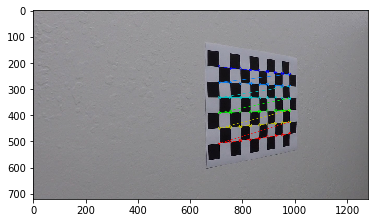

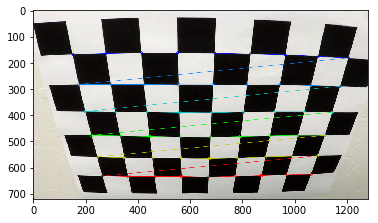

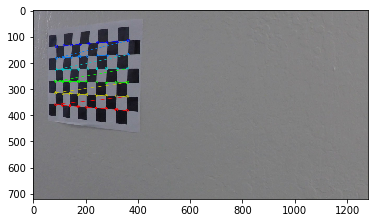

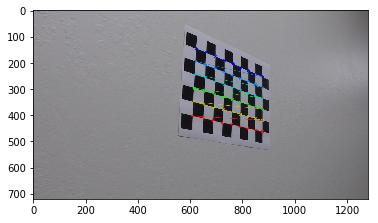

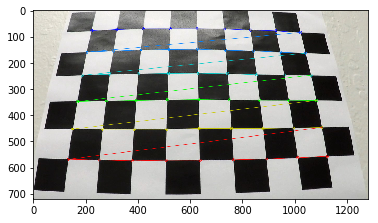

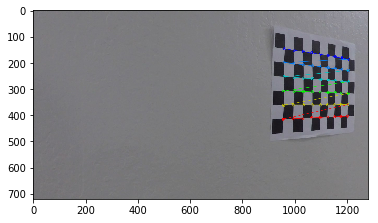

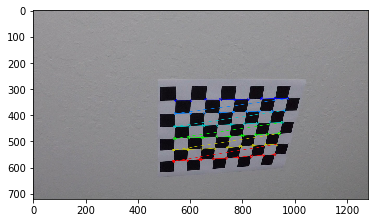

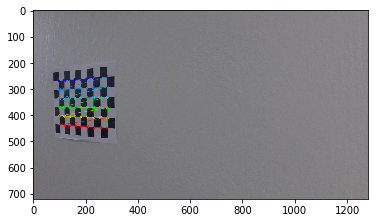

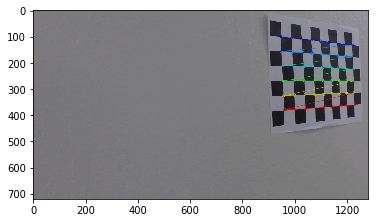

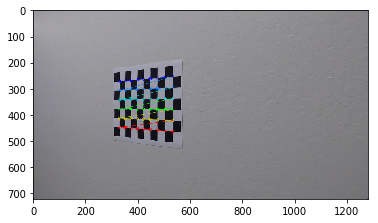

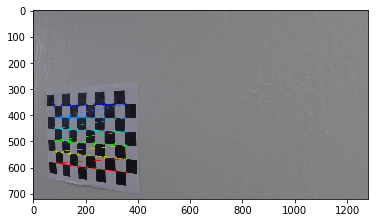

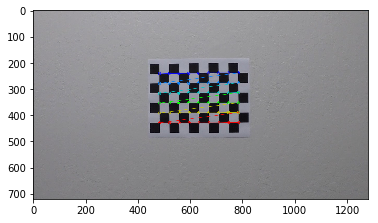

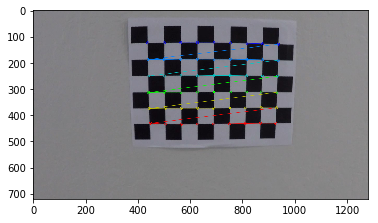

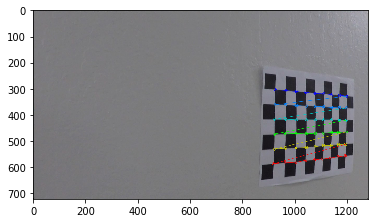

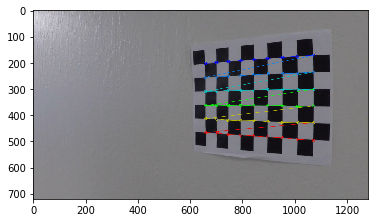

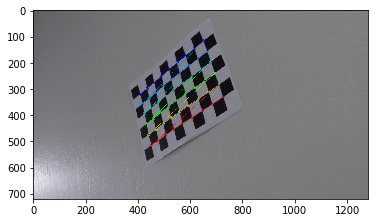

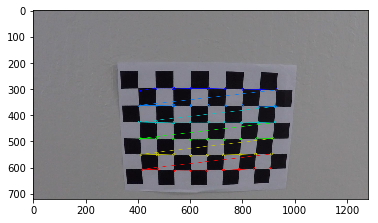

In [4]:
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Calculate calibration parameters 
mtx, dist = compute_calibration_params(nx, ny, fnames)

Use 'camera/cal/calibration1.jpg' as test image:

In [5]:
# Apply undistort function to the color image (which was read by plt, not cv2)
def apply_undistort(img, outname):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Calculate the un-distort image based on the calibration matrix and distortion coefficients
    # NOTE: use original color image, not gray image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

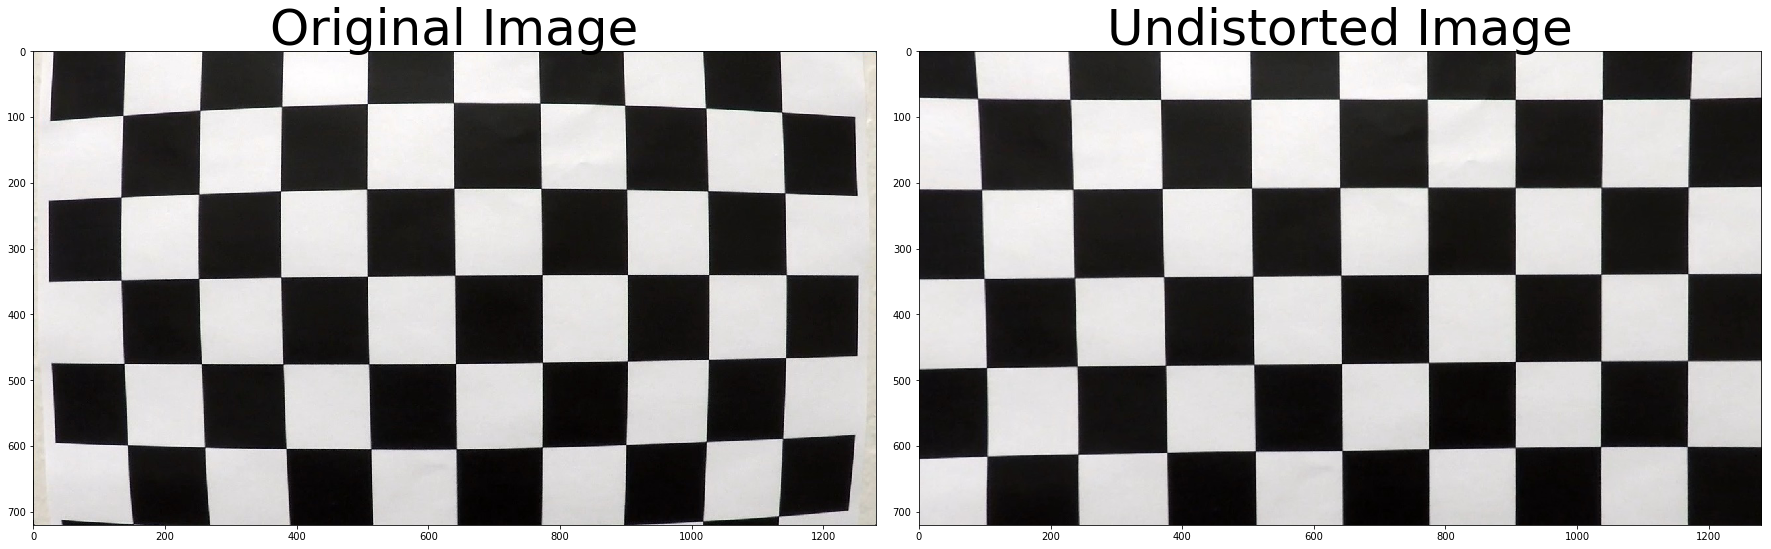

In [6]:
test_fname = 'camera_cal/calibration1.jpg'
test_out_name = 'output_images/calibration1_undistort.png'
img = plt.imread(test_fname)
undist = apply_undistort(img, test_out_name)
plot_2figures(img, undist, test_out_name)

## Pipeline (Single Image)
## 1. Apply a distortion correction to raw images.

Similar as the testing in the section of camera calibration, apply undistort function to 'test_images/test1.jpg'. From the result we can see the distortion esp. in the bottom area was nicely corrected.

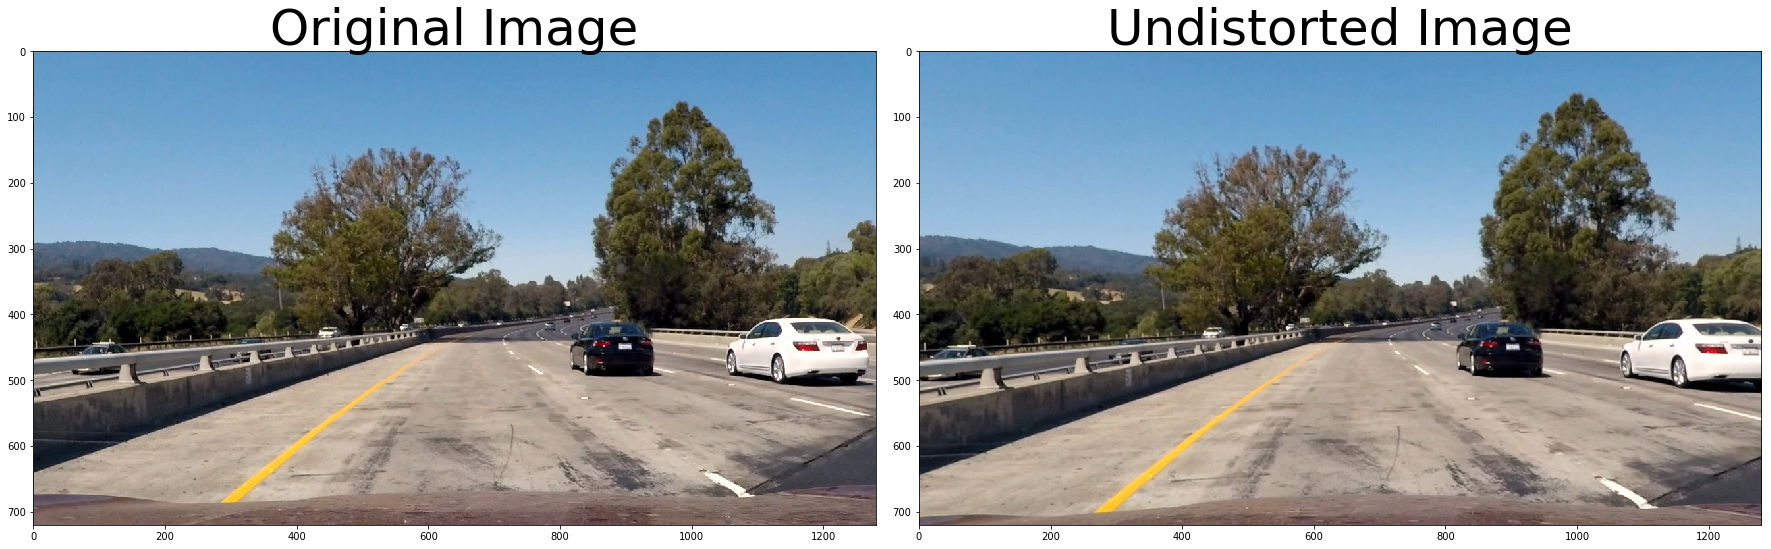

In [7]:
fname = 'test_images/test1.jpg'
out_name = 'output_images/test1_undistort.png'
img = plt.imread(fname)
undist = apply_undistort(img, out_name)
plot_2figures(img, undist, out_name)

## 2. Use color transforms and gradients to create a thresholded binary image.

In [8]:
# Thresholding the image based on HLS color space and the gradients of S,
# return the thresholded image
def threshold_img(img, s_thresh=(150, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine binaries
    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1) | (s_channel == 1)] = 1
    return combined 

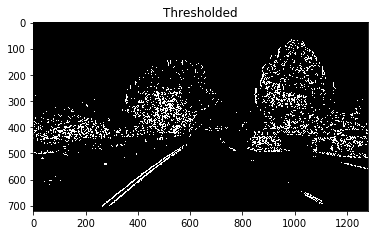

In [9]:
# Use the undisted image as input,
# apply threshold to get binary image
thresholded = threshold_img(undist)
plt.imshow(thresholded, cmap='gray')
plt.title('Thresholded')
plt.savefig('output_images/test1_binary.png')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

In [10]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  

    return warped, Minv

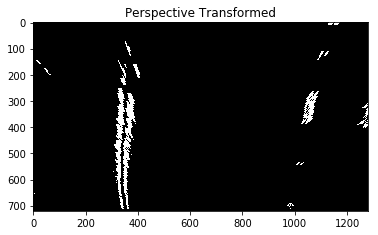

In [11]:
img_size = thresholded.shape[::-1]

# Trapozoid area 
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

# Target area in bird view image
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

warped, Minv = warper(thresholded, src, dst)
plt.imshow(warped, cmap='gray')
plt.title('Perspective Transformed')
plt.savefig('output_images/test1_warped.png')

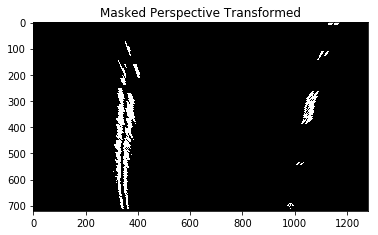

In [12]:
# The left and right margin will be removed
# I saw some noise/bad pixels in these area, which makes fitting less accurate
def mask_binaryimg(binary):
    img_height = binary.shape[0]
    img_width = binary.shape[1]
    margin =  80
    src = np.float32(
    [[margin, 0],
     [margin, img_height],
     [img_width-margin,img_height],
     [img_width-margin, 0]])
    a3 = np.array([np.int_(src)], dtype=np.int32)
    im = np.zeros_like(binary).astype(np.uint8)
    cv2.fillPoly(im, a3, 1)

    result = cv2.bitwise_or(binary, binary, mask=im)
    return result

masked_warped = mask_binaryimg(warped)
plt.imshow(masked_warped, cmap='gray')
plt.title('Masked Perspective Transformed')
plt.savefig('output_images/test1_masked_warped.png')

## 4. Detect lane pixels and fit to find the lane boundary.

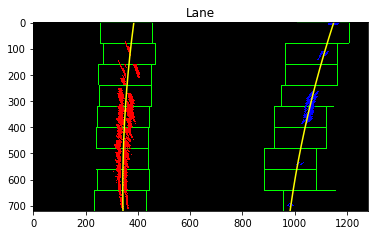

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the image
    # Note: the bottom half image was used in the course/lecture,
    # changed it to whole image for better result
    histogram = np.sum(binary_warped, axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(masked_warped)

plt.imshow(out_img)
plt.title('Lane')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig('output_images/test1_lane.png')

## 5. Determine the curvature of the lane and vehicle position with respect to center.

In [14]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_ws = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_ws = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_ws[0]*y_eval*ym_per_pix + left_fit_ws[1])**2)**1.5) / np.absolute(2*left_fit_ws[0])
    right_curverad = ((1 + (2*right_fit_ws[0]*y_eval*ym_per_pix + right_fit_ws[1])**2)**1.5) / np.absolute(2*right_fit_ws[0])
    left_curverad = "Left curvature: {:.2f} m".format(left_curverad)
    right_curverad = "Right curvature: {:.2f} m".format(right_curverad)
    
    # Lane center is mid of left and right lane bottom                        
    lane_center = np.sum((left_fitx + right_fitx)/2., axis=0) / len(left_fitx)
    
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {} of center".format(center, position)
    
    return left_curverad, right_curverad, center


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, center = measure_curvature_real(ploty, left_fitx, right_fitx)

print(left_curverad, '\n', right_curverad, '\n', center)

Left curvature: 1564.31 m 
 Right curvature: 1267.93 m 
 Vehicle is 0.34m right of center


## 6. Warp the detected lane boundaries back onto the original image.

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

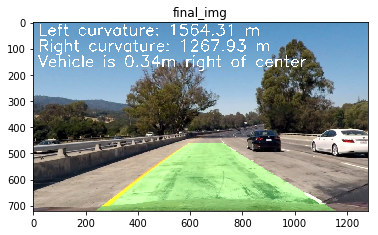

In [15]:
def warp_lanes_on_img(undist, warped_img, left_fit, right_fit, Minv, left_curverad, right_curverad, center):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warp_back = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, warp_back, 0.3, 0)
    
    # Add text on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    fontColor = (255,255,255)
    lineType = 3
    cv2.putText(result, left_curverad, (20,50), font, fontScale, fontColor, lineType)
    cv2.putText(result, right_curverad, (20,110), font, fontScale, fontColor, lineType)
    cv2.putText(result, center, (20,170), font, fontScale, fontColor, lineType)
    
    return result
    
final_img = warp_lanes_on_img(undist, masked_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, center)
plt.imshow(final_img)
plt.title('final_img')
plt.savefig('output_images/test1_final_img.png')

The whole pipeline:

In [16]:
def lane_finding(img):
    # Apply a distortion correction to raw images
    undist = apply_undistort(img, out_name)
    
    # Use color transforms and gradients to create a thresholded binary image.
    thresholded = threshold_img(undist)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view")
    warped, Minv = warper(thresholded, src, dst)
    
    # Mask left and right margin
    masked_warped = mask_binaryimg(warped)
    
    # Detect lane pixels and fit to find the lane boundary.
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(masked_warped)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad, center = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    # Final display
    final_img = warp_lanes_on_img(undist, masked_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, center)
    
    return final_img

Run test images:

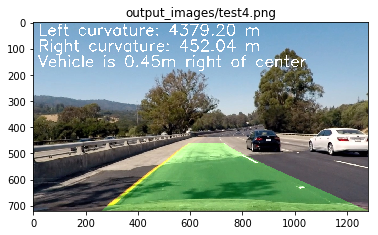

In [17]:
test_names = glob.glob('test_images/*.jpg')
count = 1
for name in test_names:
        img = plt.imread(name)
        out_name = name.replace('test_images', 'output_images')
        out_name = out_name.replace('.jpg', '.png')
        final_img = lane_finding(img)
        plt.imshow(final_img)
        plt.title(out_name)
        plt.savefig(out_name)

## Pipeline (Video)

The pipeline for video is almost the same as the pipeline for single image, except that Polynomial fit values can be found from the previous frame.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [ ]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

In [ ]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # eturn the final output (image where lines are drawn on lanes)
    
    # Apply a distortion correction to raw images
    undist = apply_undistort(img, out_name)
    
    # Use color transforms and gradients to create a thresholded binary image.
    thresholded = threshold_img(undist)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view")
    warped, Minv = warper(thresholded, src, dst)
    
    # Mask left and right margin
    masked_warped = mask_binaryimg(warped)
    
    # Detect lane pixels and fit to find the lane boundary.
    if lane.counter == 0:
        out_img, ploty, lane.left_fit, lane.right_fit, left_fitx, right_fitx = fit_polynomial(masked_warped)
    else:
        out_img, ploty, lane.left_fit, lane.right_fit, left_fitx, right_fitx = search_around_poly(masked_warped, lane.left_fit, lane.right_fit)
        
    lane.counter = lane.counter + 1
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad, center = measure_curvature_real(ploty, left_fit, right_fit)
    
    # Final display
    final_img = warp_lanes_on_img(undist, masked_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, center) 
    return final_img

In [ ]:
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        
        
lane = Lane()

video_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("project_video.mp4")

video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))